## **Instalação de dependências (adicionando scikit-image)**

In [ ]:
!pip install tensorflow scikit-image

## **Imports necessários**

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.filters import threshold_sauvola
from google.colab import drive

## **Montar o Drive (sem alteração)**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Definir diretórios**

In [ ]:
# Diretório principal dos datasets
train_dir = 
test_dir = 

# Caminho do arquivo CSV com as labels
train_labels_csv_path = 
test_labels_csv_path = 

## **Função para pré-processar imagens**

In [ ]:
def preprocess_digit_image_for_hog(img_path, target_size=(56, 56)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Não foi possível ler a imagem: {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)

    # Binarização de Sauvola [cite: 148, 262]
    # O artigo menciona k=0.34 e W_sauv = 0.059 * H_img para a tela cheia. [cite: 199, 200]
    # Para dígitos 56x56, um window_size menor é apropriado.
    # Valores típicos para window_size são ímpares, ex: 15, 25. k entre 0.2 e 0.5.
    window_size = 25 # Deve ser ajustado empiricamente
    k_sauvola = 0.34
    try:
        thresh_sauvola = threshold_sauvola(img_resized, window_size=window_size, k=k_sauvola)
        img_binarized = (img_resized > thresh_sauvola).astype(np.uint8) * 255
        # Inverter se necessário para ter segmentos pretos (0) em fundo branco (255)
        # ou segmentos brancos (255) em fundo preto (0).
        # A Figura 4 do artigo mostra segmentos pretos em fundo branco.
        # Se threshold_sauvola produz segmentos brancos, inverta:
        # img_binarized = (img_resized <= thresh_sauvola).astype(np.uint8) * 255
    except Exception as e:
        print(f"Erro na binarização de Sauvola para {img_path}: {e}. Usando Otsu como fallback.")
        _, img_binarized = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    # HOG geralmente espera objetos claros em fundo escuro, ou o contrário de forma consistente.
    # Para este exemplo, retornaremos a imagem em tons de cinza redimensionada,
    # pois HOG pode ser calculado diretamente sobre ela e é uma prática comum.
    # O artigo, no entanto, binariza os dígitos antes do HOG[cite: 262, 148].
    # Se for usar a binarizada, certifique-se que é uint8.
    # return img_binarized.astype(np.uint8) # Para usar a imagem binarizada
    return img_resized.astype(np.uint8) # Usando tons de cinza para HOG

## **Carregar imagens e labels**

In [ ]:
def load_images_and_labels_from_csv_for_hog(image_folder, labels_df, target_size=(56, 56)):
    X_data, y_data = [], []
    for index, row in labels_df.iterrows():
        image_name = row['file']
        label = row['label']

        # Construir o caminho completo da imagem
        # 1. Remover "./dataset/train/" do início do caminho (se necessário)
        image_name = image_name.replace("./dataset/train/", "")
        image_name = image_name.replace("./dataset/validation/", "")
        # 2. Combinar com o caminho base da pasta 'image_folder'
        image_path = os.path.join(image_folder, image_name)

        if os.path.exists(image_path):
            processed_img = preprocess_digit_image_for_hog(image_path, target_size)
            if processed_img is not None:
                X_data.append(processed_img)
                y_data.append(row['label'])
        else:
            print(f"Imagem não encontrada: {image_path} (original: {image_name_full})")
    return np.array(X_data), np.array(y_data)

## **Função para extrair características HOG**

In [ ]:
def extract_hog_features(images_array):
    hog_features_list = []
    # Parâmetros HOG para obter 1296 características de uma imagem 56x56 [cite: 271]
    winSize = (56, 56)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    for img in images_array:
        # HOG espera imagens uint8
        if img.dtype != np.uint8:
            # Se normalizadas (0-1), converta de volta para 0-255
            img_uint8 = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        else:
            img_uint8 = img

        features = hog.compute(img_uint8)
        hog_features_list.append(features.flatten())

    return np.array(hog_features_list)

## **Carregar os dados e pré-processar**

In [ ]:
train_labels_df = pd.read_csv(train_labels_csv_path)
test_labels_df = pd.read_csv(test_labels_csv_path)

print("Carregando e pré-processando dados de treinamento...")
X_train_img, y_train = load_images_and_labels_from_csv_for_hog(train_dir, train_labels_df)
print("Carregando e pré-processando dados de teste...")
X_test_img, y_test = load_images_and_labels_from_csv_for_hog(test_dir, test_labels_df)

if X_train_img.size == 0 or X_test_img.size == 0:
    raise ValueError("Nenhuma imagem foi carregada. Verifique os caminhos e a estrutura do CSV.")

print(f"Formato de X_train_img: {X_train_img.shape}")
print(f"Formato de X_test_img: {X_test_img.shape}")


num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Extraindo características HOG dos dados de treinamento...")
X_train_hog = extract_hog_features(X_train_img)
print("Extraindo características HOG dos dados de teste...")
X_test_hog = extract_hog_features(X_test_img)

print(f"Formato de X_train_hog: {X_train_hog.shape}")
print(f"Formato de X_test_hog: {X_test_hog.shape}")

if X_train_hog.shape[0] == 0:
    raise ValueError("Nenhuma característica HOG foi extraída para o conjunto de treinamento.")
if X_test_hog.shape[0] == 0:
    raise ValueError("Nenhuma característica HOG foi extraída para o conjunto de teste.")

input_dim_hog = X_train_hog.shape[1]
if input_dim_hog != 1296:
    print(f"Alerta: Dimensão HOG esperada era 1296, mas obteve {input_dim_hog}. Verifique os parâmetros HOG.")

Carregando e pré-processando dados de treinamento...
Carregando e pré-processando dados de teste...
Formato de X_train_img: (10000, 56, 56)
Formato de X_test_img: (4000, 56, 56)
Extraindo características HOG dos dados de treinamento...
Extraindo características HOG dos dados de teste...
Formato de X_train_hog: (10000, 1296)
Formato de X_test_hog: (4000, 1296)


## **Carregar os dados e pré-processar**

In [ ]:
train_labels_df = pd.read_csv(train_labels_csv_path)
test_labels_df = pd.read_csv(test_labels_csv_path)

print("Carregando e pré-processando dados de treinamento...")
X_train_img, y_train = load_images_and_labels_from_csv_for_hog(train_dir, train_labels_df)
print("Carregando e pré-processando dados de teste...")
X_test_img, y_test = load_images_and_labels_from_csv_for_hog(test_dir, test_labels_df)

if X_train_img.size == 0 or X_test_img.size == 0:
    raise ValueError("Nenhuma imagem foi carregada. Verifique os caminhos e a estrutura do CSV.")

print(f"Formato de X_train_img: {X_train_img.shape}")
print(f"Formato de X_test_img: {X_test_img.shape}")


num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Extraindo características HOG dos dados de treinamento...")
X_train_hog = extract_hog_features(X_train_img)
print("Extraindo características HOG dos dados de teste...")
X_test_hog = extract_hog_features(X_test_img)

print(f"Formato de X_train_hog: {X_train_hog.shape}")
print(f"Formato de X_test_hog: {X_test_hog.shape}")

if X_train_hog.shape[0] == 0:
    raise ValueError("Nenhuma característica HOG foi extraída para o conjunto de treinamento.")
if X_test_hog.shape[0] == 0:
    raise ValueError("Nenhuma característica HOG foi extraída para o conjunto de teste.")

input_dim_hog = X_train_hog.shape[1]
if input_dim_hog != 1296:
    print(f"Alerta: Dimensão HOG esperada era 1296, mas obteve {input_dim_hog}. Verifique os parâmetros HOG.")

Carregando e pré-processando dados de treinamento...
Carregando e pré-processando dados de teste...
Formato de X_train_img: (10000, 56, 56)
Formato de X_test_img: (4000, 56, 56)
Extraindo características HOG dos dados de treinamento...
Extraindo características HOG dos dados de teste...
Formato de X_train_hog: (10000, 1296)
Formato de X_test_hog: (4000, 1296)


## **Pré-processamento e treino**

In [ ]:
# Calcular pesos para balanceamento das classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Definir o modelo MLP [cite: 271, 268]
model_mlp = Sequential([
    Dense(56, activation='relu', input_dim=input_dim_hog, kernel_regularizer=l2(0.0005)), # Camada oculta com 56 unidades
    Dropout(0.4), # O artigo não menciona dropout para MLP, mas pode ser útil
    Dense(num_classes, activation='softmax')
])

# Compilar o modelo MLP
model_mlp.compile(
    optimizer=Adam(learning_rate=0.001), # O artigo usa Levenberg-Marquardt [cite: 269]
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mlp.summary() # Para verificar a arquitetura

# Configurar callbacks (mantido)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Treinar o modelo MLP
# Removido train_datagen.flow, pois não usamos mais ImageDataGenerator com HOG
print("Iniciando treinamento do modelo MLP...")
history = model_mlp.fit(
    X_train_hog, y_train_cat,
    epochs=100, # Ajuste conforme necessário; MLPs podem precisar de mais épocas
    validation_data=(X_test_hog, y_test_cat),
    class_weight=class_weights_dict, # Manter se as classes forem desbalanceadas
    callbacks=callbacks,
    batch_size=32 # Adicionado batch_size explícito
)

# Avaliar o modelo
print("Avaliando o modelo MLP...")
test_loss, test_acc = model_mlp.evaluate(X_test_hog, y_test_cat)
print(f"Acurácia MLP nos dados de teste: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 56)             │        72,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,202 (285.95 KB)

 Trainable params: 73,202 (285.95 KB)

 Non-trainable params: 0 (0.00 B)

Iniciando treinamento do modelo MLP...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3578 - loss: 1.9460 - val_accuracy: 0.8605 - val_loss: 0.8593 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7965 - loss: 0.8446 - val_accuracy: 0.9260 - val_loss: 0.5252 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8779 - loss: 0.5776 - val_accuracy: 0.9565 - val_loss: 0.3937 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9057 - loss: 0.4740 - val_accuracy: 0.9578 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9356 - loss: 0.4048 - val_accuracy: 0.9730 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9421 - loss: 0.3704 - val_accuracy: 0.9745 - val_loss: 0.2798 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s

## **Salvar modelo**

Saved artifact at '/tmp/tmpaa7ehq7l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1296), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139598976063760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139598976068752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139598976066064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139598976067024: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelos salvos em /content/drive/MyDrive/Faculdade/Materias/TG/Modelo_Sete_Segmento/seven_segment_model_mlp.keras e /content/drive/MyDrive/Faculdade/Materias/TG/Modelo_Sete_Segmento/seven_segment_model_mlp.tflite


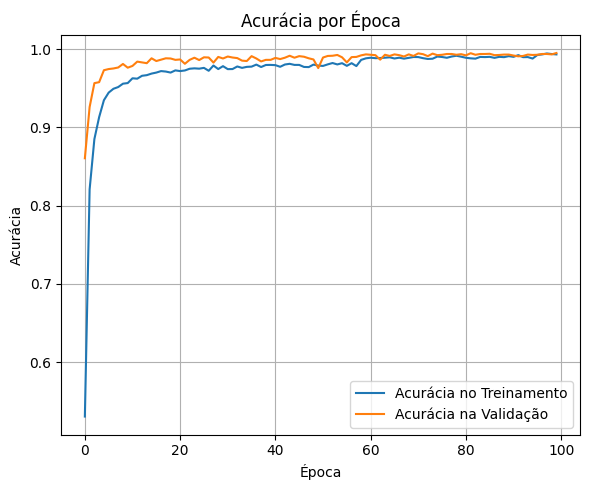

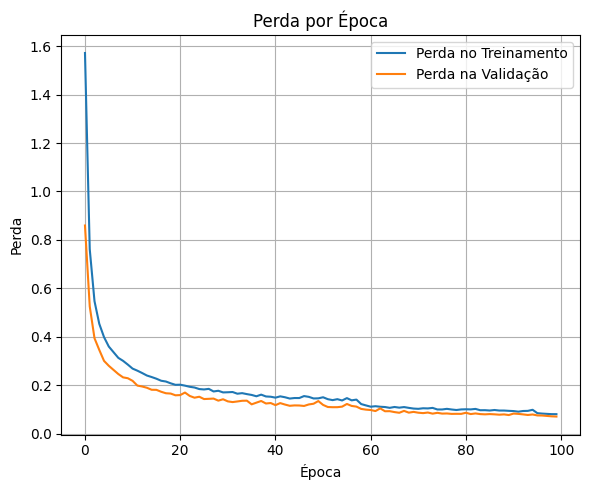

In [ ]:
# Escolher local para salvar os modelos Keras e tflite

keras_model_path = 
tflite_model_path = 

model_mlp.save(keras_model_path)

# Para converter para TFLite, o modelo Keras precisa ser construído.
# Se o input_dim foi determinado dinamicamente, pode ser necessário definir explicitamente para a conversão
# ou garantir que o modelo foi "chamado" (treinado/avaliado).
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model_mlp)
    tflite_model = converter.convert()
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Modelos salvos em {keras_model_path} e {tflite_model_path}")
except Exception as e:
    print(f"Erro ao converter para TFLite: {e}")
    print("Certifique-se de que o modelo pode ser construído. Input_shape pode ser necessário.")


# Gráfico de Acurácia
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de Perda
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Matriz de confusão**

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


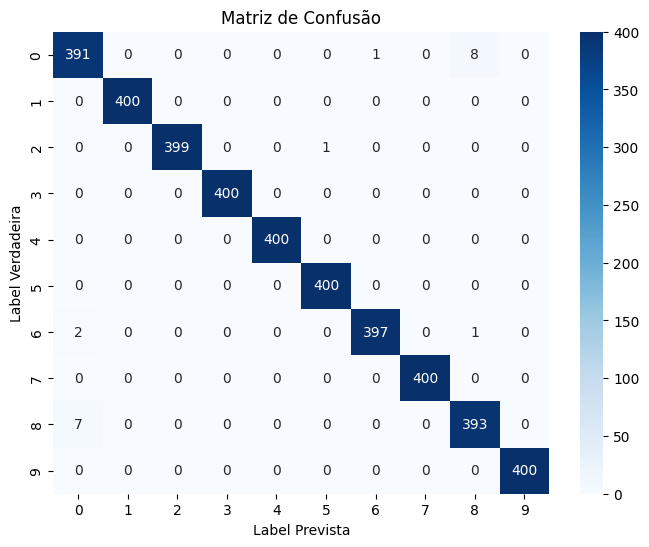

In [ ]:
# Gerar previsões
y_pred_proba = model_mlp.predict(X_test_hog)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1) # Ou use y_test diretamente se não for one-hot encoded ainda

# Calcular matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Label Prevista')
plt.ylabel('Label Verdadeira')
plt.title('Matriz de Confusão')
plt.show()